# Sleep stage classification on single channel EEG-Spectogram (F4-M1)
* Classifier: Neural network (CNN, Dense)
* Training: 700 records, 9 epochs
* Validation on unseen data: 
    * 294 record: accuracy=0.72, $\kappa$=0.61 
    * 1 record: accuracy=0.77, $\kappa$=0.66

In [2]:
import wfdb
import matplotlib.pyplot as plt
from constants import *
from main import *
import h5py
import librosa as lr
import matplotlib.pyplot as plt
from librosa import display
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import OneHotEncoder
import os
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter("ignore", UserWarning)
import pandas as pd

from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score


In [3]:
gpu_id = 0 # Select GPU to be used: 0-3
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[gpu_id], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[gpu_id], True)

    except RuntimeError as e:
        print(e)

In [4]:
def transform_undef(hypnogram):
    hypnogram[hypnogram == 0] = 5
    return hypnogram

def get_sleep_stages(record):
    stages,_,_ = get_converted_sleep_stages(TRAIN_PATH+record+"-arousal.mat")
    return transform_undef(stages[0:len(stages):30*200])

def get_signal(record):
    # 'F4-M1'
    signal = wfdb.rdrecord(TRAIN_PATH+record, channels=[1]).p_signal
    return signal.reshape((len(signal),))

def get_validation_input(record):
    X = []
    signal = get_signal(record)
        
    while signal.size != 0:
        if signal[0:30*200].size != 6000:
            pass
        else:
            # calculate spectogram (db)
            X.append(lr.amplitude_to_db(
                lr.stft(y=signal[0:30*200], 
                        n_fft=255, hop_length=256)))
            signal = signal[30*200:]
    return np.array(X)

def get_classification_input(record_list):
    X = []
    Y = np.array([])
    
    for record in record_list:
        signal = get_signal(record)
        s_stages = get_sleep_stages(record)
        
        while signal.size != 0:
            if signal[0:30*200].size != 6000:
                # remove the last element from s_stages
                s_stages = np.delete(s_stages, -1)
                pass
            else:
                # calculate spectogram (db)
                X.append(lr.amplitude_to_db(
                    lr.stft(y=signal[0:30*200], 
                            n_fft=255, hop_length=256)))
            signal = signal[30*200:]
            
        Y = np.append(Y, s_stages)
    return np.array(X), Y
    
def contingency_table(conf_mat):
    total = np.sum(conf_mat)
    total_rand = np.sum(conf_mat, axis=0)
    
    total_real = np.sum(conf_mat, axis=1)
    total_real = np.append(total_real, total)
    
    conf_mat = np.vstack((conf_mat, total_rand))
    
    return np.concatenate((conf_mat, total_real[:, None]), axis=1)


def get_mask():
    my_mask = np.array([[False,False,False,False,False,True],
                        [False,False,False,False,False,True],
                        [False,False,False,False,False,True],
                        [False,False,False,False,False,True],
                        [False,False,False,False,False,True],
                        [True,True,True,True,True,True]])
    return my_mask


## Train on 700 records

In [11]:
record_list = get_all_records(TRAIN_PATH, "RECORDS")
rec = record_list[:700]

## Preprocessing

In [13]:
# Create input data
X, Y = get_classification_input(rec)

print(X.shape, "\t", Y.shape)
Y

(646610, 128, 24) 	 (646610,)


array([5., 5., 5., ..., 4., 4., 4.])

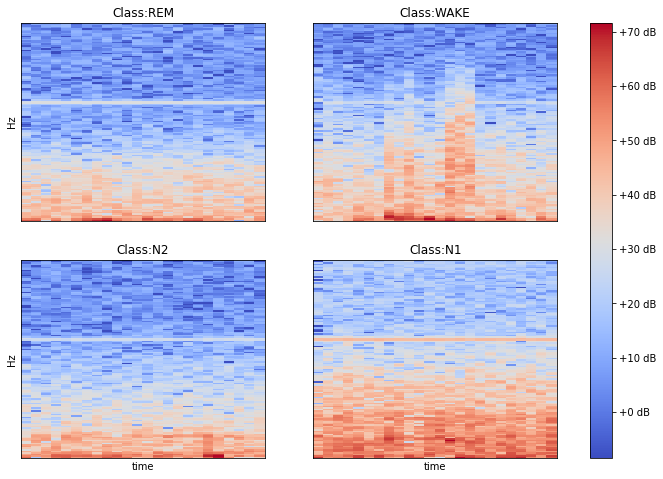

In [10]:
# Visualize the data

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(12, 8))
ax0, ax1, ax2, ax3 = axes.flatten()

img=lr.display.specshow(X[200], ax=ax0, sr=200)
ax0.set_title("Class:{}".format(TICK_LABELS.get(Y[200])))
ax0.set_ylabel("Hz")

lr.display.specshow(X[2], ax=ax1, sr=200)
ax1.set_title("Class:{}".format(TICK_LABELS.get(Y[2])))

lr.display.specshow(X[80], ax=ax2, sr=200)
ax2.set_title("Class:{}".format(TICK_LABELS.get(Y[80])))
ax2.set_xlabel("time")
ax2.set_ylabel("Hz")
ax2.set_xticks([np.linspace(0,30,10)])

lr.display.specshow(X[20], ax=ax3, sr=200)
ax3.set_title("Class:{}".format(TICK_LABELS.get(Y[20])))
ax3.set_xlabel("time")

fig.colorbar(img, ax=axes, format="%+2.f dB")
plt.show()

In [8]:
# One Hot Encoding
Y = Y.reshape(-1, 1)
encoder = OneHotEncoder().fit(Y)
Y = encoder.transform(Y).toarray()

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, shuffle=True)
X_train = tf.expand_dims(X_train, axis=-1)
X_val = tf.expand_dims(X_val, axis=-1)

print("training:", X_train.shape, Y_train.shape)
print("validation:", X_val.shape, Y_val.shape)

training: (517288, 128, 24, 1) (517288, 5)
validation: (129322, 128, 24, 1) (129322, 5)


## Model

In [9]:
class Model:
    def __init__(self):
        self.model = tf.keras.Sequential([
            layers.Conv2D(filters=16, kernel_size=(3, 3), activation="relu", padding="same",
                         input_shape=(128, 24, 1)),
            layers.MaxPool2D(pool_size=(2, 2), padding="same"),
            layers.Conv2D(filters=8, kernel_size=(2, 2), activation="relu",padding="same"),
            layers.MaxPool2D(pool_size=(2, 2), padding="same"),
            layers.Conv2D(filters=4, kernel_size=(2, 2), activation="relu",padding="same"),
            layers.Flatten(),
            layers.Dense(100, input_shape=(192,), activation="relu"),
            layers.Dense(80, activation="relu"),
            layers.Dense(60, activation="relu"),
            layers.Dense(5, activation="softmax")
        ])
    def get_model(self):
        return self.model

In [10]:
model = Model()
model = model.get_model()

In [11]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

## Training

In [12]:
hist = model.fit(
    X_train,
    Y_train,
    batch_size=32,
    shuffle=True,
    epochs=100,
    validation_data=(X_val, Y_val),
    callbacks=[callback]
)
model.save("model3")

Epoch 1/100
16166/16166 [==============================] - 89s 5ms/step - loss: 0.8182 - accuracy: 0.6715 - val_loss: 0.7691 - val_accuracy: 0.6928
Epoch 2/100
16166/16166 [==============================] - 87s 5ms/step - loss: 0.7543 - accuracy: 0.6985 - val_loss: 0.7306 - val_accuracy: 0.7074
Epoch 3/100
16166/16166 [==============================] - 88s 5ms/step - loss: 0.7378 - accuracy: 0.7057 - val_loss: 0.7316 - val_accuracy: 0.7098
Epoch 4/100
16166/16166 [==============================] - 91s 6ms/step - loss: 0.7290 - accuracy: 0.7091 - val_loss: 0.7195 - val_accuracy: 0.7115
Epoch 5/100
16166/16166 [==============================] - 90s 6ms/step - loss: 0.7222 - accuracy: 0.7116 - val_loss: 0.7106 - val_accuracy: 0.7156
Epoch 6/100
16166/16166 [==============================] - 89s 5ms/step - loss: 0.7170 - accuracy: 0.7145 - val_loss: 0.7054 - val_accuracy: 0.7188
Epoch 7/100
16166/16166 [==============================] - 89s 5ms/step - loss: 0.7125 - accuracy: 0.7161 - val_

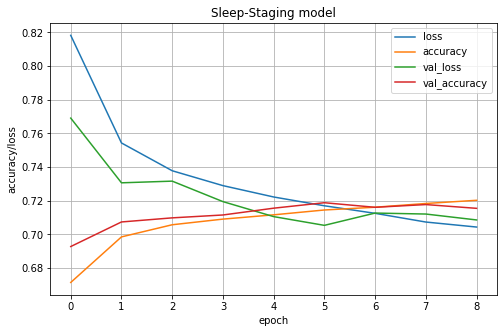

In [13]:
pd.DataFrame(hist.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title("Sleep-Staging model")
plt.xlabel("epoch")
plt.ylabel("accuracy/loss")
plt.show()

## Validate the model on unseen data

In [3]:
model = tf.keras.models.load_model('model3')

In [7]:
unseen_rec = record_list[700:len(record_list)]

X_unseen, Y_unseen = get_classification_input(unseen_rec)
X_unseen = tf.expand_dims(X_unseen, axis=-1)

X_unseen1, Y_unseen1 = get_classification_input(record_list[800:801])
X_unseen1 = tf.expand_dims(X_unseen1, axis=-1)

In [8]:
print(len(unseen_rec),"records:\t",X_unseen.shape, "\t", Y_unseen.shape)
print("1 record:\t",X_unseen1.shape, "\t", Y_unseen1.shape)

294 records:	 (272636, 128, 24, 1) 	 (272636,)
1 record:	 (858, 128, 24, 1) 	 (858,)


In [9]:
Y_predict = model.predict_classes(X_unseen)
Y_predict1 = model.predict_classes(X_unseen1)

Y_predict+=1
Y_predict1+=1

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [10]:
acc = accuracy_score(Y_unseen, Y_predict)
kappa = cohen_kappa_score(Y_unseen, Y_predict)

acc1 = accuracy_score(Y_unseen1, Y_predict1)
kappa1 = cohen_kappa_score(Y_unseen1, Y_predict1)

print(len(unseen_rec),"records:\t",acc, kappa)
print("1 record:\t",acc1, kappa1)

294 records:	 0.7169045907363665 0.6077752183115317
1 record:	 0.7680652680652681 0.657350305740128


In [11]:
cm = confusion_matrix(Y_unseen, Y_predict)
cm1 = confusion_matrix(Y_unseen1, Y_predict1)

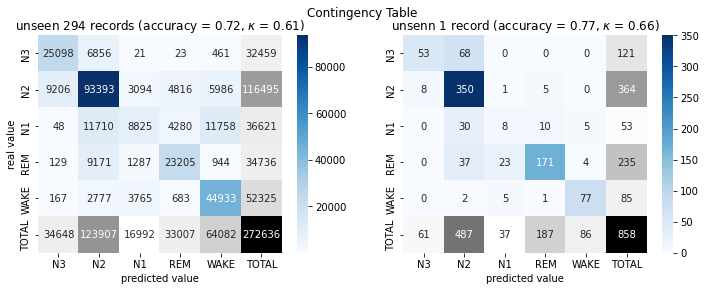

In [28]:
# contingemcy table
labels = ["N3","N2","N1","REM","WAKE", "TOTAL"]
title = "(accuracy = {:.2f}, $\kappa$ = {:.2f})".format(acc, kappa)
title1 = "(accuracy = {:.2f}, $\kappa$ = {:.2f})".format(acc1, kappa1)

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(12, 4))
ax0, ax1 = axes.flatten()

# Plot (left side)
sns.heatmap(contingency_table(cm),cmap="Blues", fmt="d", annot=True, yticklabels=labels,
            xticklabels=labels, mask=get_mask(), ax=ax0)
sns.heatmap(contingency_table(cm), fmt="d", annot=True, yticklabels=labels,
            xticklabels=labels, mask=~get_mask(), cbar=False, cmap="binary", ax=ax0)
ax0.set_ylabel("real value")
ax0.set_xlabel("predicted value")
ax0.set_title("unseen {:d} records ".format(len(unseen_rec))+title)

# Plot (right side)
sns.heatmap(contingency_table(cm1),cmap="Blues", fmt="d", annot=True,
            xticklabels=labels, mask=get_mask(), ax=ax1)
sns.heatmap(contingency_table(cm1), fmt="d", annot=True,yticklabels=labels,
            xticklabels=labels, mask=~get_mask(), cmap="binary", cbar=False, ax=ax1)
ax1.set_xlabel("predicted value")
ax1.set_title("unsenn 1 record "+title1)
fig.suptitle("Contingency Table",size=12)
plt.show()